Emphasize:
- Problem Solving Skills
- Exploratory Data Analysis
- Understand Problem domain

In [50]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/winton/train.csv', index_col='Id')

Error function for Evaluation
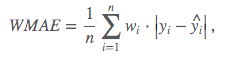

# Strategy

- [X] Data Cleaning
    - Deal with NaNs
    - Mask data
- [X 2HRS] EDA
    - Naive Model
        - Look at residuals
- [X .25HRS] Setup Cross Validating (will figure this out on Naive Model)
- [10 HRS] Model Improvements

- [estimated 3 HRS] Potential future improvements
    - DTW with KNN (k=1?)
        - [https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb]
        - Or possibly: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
    - Clustering
        - kmeans/GMM on features
        - Hierarchical clustering on DTW distances
    - Clustering and stacking based on membership?
    - Make a somewhat sequential model where D+2 is calculated from D+1

In [3]:
mask_exog_return_days = ['Ret_MinusTwo', 'Ret_MinusOne']
mask_endog_return_days = ['Ret_PlusOne', 'Ret_PlusTwo']

mask_exog_feature = [i for i in df.columns if 'Feature_' in i]
mask_exog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_exog_return = [i for i in mask_exog_return if int(i.split('_')[1]) <= 120]
mask_exog = mask_exog_return + mask_exog_feature
mask_exog = mask_exog_return_days + mask_exog

mask_endog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_endog_return = [i for i in mask_endog_return if int(i.split('_')[1]) > 120]
mask_endog = mask_endog_return + mask_endog_return_days

mask_weights = ['Weight_Intraday', 'Weight_Daily']

### Data Cleaning

In [4]:
df.dtypes

Feature_1          float64
Feature_2          float64
Feature_3          float64
Feature_4          float64
Feature_5          float64
Feature_6          float64
Feature_7            int64
Feature_8          float64
Feature_9          float64
Feature_10         float64
Feature_11         float64
Feature_12         float64
Feature_13         float64
Feature_14         float64
Feature_15         float64
Feature_16         float64
Feature_17         float64
Feature_18         float64
Feature_19         float64
Feature_20         float64
Feature_21         float64
Feature_22         float64
Feature_23         float64
Feature_24         float64
Feature_25         float64
Ret_MinusTwo       float64
Ret_MinusOne       float64
Ret_2              float64
Ret_3              float64
Ret_4              float64
                    ...   
Ret_155            float64
Ret_156            float64
Ret_157            float64
Ret_158            float64
Ret_159            float64
Ret_160            float64
R

Not sure what 'Feature_7' is. Maybe it's a population? Will keep this in mind throughout. 

In [5]:
df['Feature_7']

Id
1        75751
2        17369
3         8277
4        22508
5        22423
6        24099
7        39351
8        92214
9        18418
10       47637
11       51499
12       79888
13       63267
14       35023
15       76131
16       69564
17       94022
18       16080
19       14259
20       65146
21       47683
22       35266
23       49660
24       57773
25       34161
26       64351
27       19660
28       94975
29       99483
30       40712
         ...  
39971    54939
39972    76736
39973    62179
39974    39562
39975    34124
39976    60280
39977    99075
39978    48365
39979    39069
39980    23153
39981    44670
39982    34324
39983    39848
39984     1344
39985    29262
39986    97667
39987    34425
39988    27661
39989    43321
39990    33304
39991    62488
39992    28859
39993    82639
39994    35409
39995    64603
39996    23729
39997    56222
39998     7024
39999    27376
40000     4141
Name: Feature_7, Length: 40000, dtype: int64

### Deal with NaNs

##### Most rows have nulls

In [5]:
df.isnull().values.any(axis=1).mean()

0.976775

In [6]:
mask_ignore_feat = list(filter(lambda x: 'Feat' not in x, mask_exog))

##### Half of the rows that have a null 'anywhere' are due to features missing. Let's ignore them for the naive model. (for now)

In [7]:
df[mask_ignore_feat]\
    .isnull().values.any(axis=1).mean()

0.44025

##### non of the endog return days are missing this is nice. 

In [8]:
df[mask_endog_return_days].isnull().values.any(axis=1).mean()

0.0

##### None of the endog minutes are missing

In [9]:
df[mask_endog].isnull().values.any(axis=1).mean()

0.0

##### none of the exogenous days are missing (D-2 and D-1)

In [10]:
df[mask_exog_return_days].isnull().mean()

Ret_MinusTwo    0.0
Ret_MinusOne    0.0
dtype: float64

#### For the missing exogenous minute time data how do we want to handle NaNs?

For exogenous minutes it looks like there's never more than 3.5% of the data missing. Since this is a pretty small I will fillna's with linearly interpolated data. I can come back to this later. 

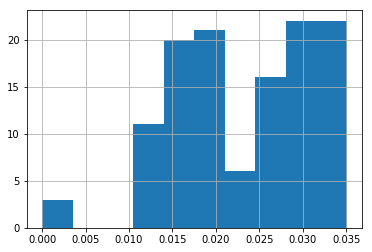

In [11]:
df[mask_ignore_feat].isnull().mean().hist()

##### Interpolate missing exogenous minutes

In [12]:
def interpolate_time(df):
    df[mask_ignore_feat] = df[mask_ignore_feat].T.interpolate().T
    return df

#### Before and after interpolation

In [13]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.44025

##### 0 nulls are left

In [14]:
df = interpolate_time(df)

In [15]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.0

#### Apply mask

In [16]:
X = df[mask_exog]
Y = df[mask_endog]
w = df[mask_weights]

done  (for now)

### Naive Model
- Residuals
- Other artifacts observations? 

Keeping things really simple.

I'm going to simply start by predicting the average return for T-121 -- 180 and then also the return for D + 1 and D + 2. 

Since there are a lot of NaN's I'm going to 

In [17]:
X['intra_return_mean'] = X[mask_exog_return].T.mean()
X['intra_return_std'] = X[mask_exog_return].T.std()
X['intra_return_max'] = X[mask_exog_return].T.max()
X['intra_return_min'] = X[mask_exog_return].T.min()

Y['intra_return_mean'] = Y[mask_endog_return].T.mean()

/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [18]:
mask_x_simple = ["intra_return_mean", "intra_return_std", "intra_return_max", "intra_return_min"]
mask_y_simple = ['intra_return_mean'] + mask_endog_return_days
Y_simple = Y[mask_y_simple]
X_simple = X[mask_x_simple + mask_exog_return_days]

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from utils import cross_validate, WMAE

cv = KFold(n_splits=5, shuffle=True, random_state=42)

model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('LinearReg', LinearRegression())])

#### WMAE

this function is moved out into a module named utils.py to make it easier to troubleshoot

w_1 weights have the intraday multiplied by 60 since we reduced from 60 features down to one aggregate feature that captures information about . Since the weight would have been applied to each of the intraday dependent variables (T-121 to T-180) it is appropriate to multiply 

In [20]:
w_1 = pd.concat([w['Weight_Intraday'] * 60, w['Weight_Daily'], w['Weight_Daily']], axis=1)

### Build and score model
- Implicit Assumptions (not necessarily intended)
    - T-120 to T-180, Day + 1, Day + 2 are independent of one another. (obv not the case) 
    - Basic out of the box RANSAC Model with no hyper parameter tuning
    
  

In [21]:
from sklearn.linear_model import LinearRegression, Lasso

In [22]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('Lasso', LinearRegression())])

x_train, x_test, y_train, y_test, w_train, w_test = \
    train_test_split(X_simple, Y_simple, w_1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

WMAE(y_test.values, y_pred, weights=w_test.values)

20846.865071384822

### Setup Cross Validation (with naive model)

This is moved into a module named utils.py

### Build and score model
- Implicit Assumptions (not necessarily intended)
    - T-120 to T-180, Day + 1, Day + 2 are independent of one another. (obv not the case) 
    - Basic out of the box RANSAC Model with no hyper parameter tuning

In [79]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('RANSAC', LinearRegression())])

model.fit(X_simple, Y_simple)

y_pred = model.predict(X_simple)

WMAE(Y_simple.values, y_pred, weights=w_1.values)

20940.156815746606

In [75]:
cross_validate(model, X_simple.values, Y_simple.values, w_1.values)

Cross Val Score: 30441.236534017342
 Cross Val Std: 4407.031324956201
 K: 3


### Build and score model Including `Features` Columns
- Add the features with prefix `Feature_`
- *Implicit* assumptions
    - Features are all independent

In [26]:
mask_simple_w_features = list(X_simple.columns) + mask_exog_feature

X_wfeatures = X[mask_simple_w_features]

##### For time's sake I'm not going to bother including features that are mostly nulls

Text(0,0.5,'Percentage Nulls')

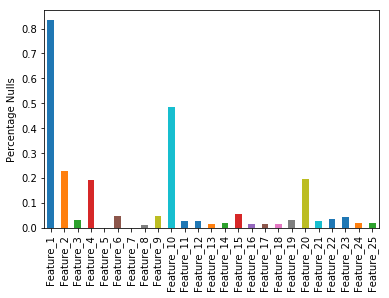

In [27]:
X_wfeatures[['Feature_{}'.format(i) for i in range(1, 26)]].isnull().mean().plot(kind='bar')
plt.ylabel('Percentage Nulls')

Let's see how we do using only features that are significantly less than 10% nulls. (just to keep things simple)

In [28]:
mask_wfeatures_columns = [i for i in X.columns 
                          if i not in ['Feature_1', 'Feature_2', 'Feature_2', 'Feature_10', 'Feature_20']
                          and i not in mask_exog_return]

# X[mask_wfeatures_columns]

In [29]:
not_na_mask = X[mask_wfeatures_columns].isnull().values.any(axis=1)

In [30]:
X_wfeatures = X[mask_wfeatures_columns][~not_na_mask]
Y_wfeatures = Y[mask_y_simple][~not_na_mask]
w_wfeatures = w_1[~not_na_mask]

### Model

In [80]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('RANSAC', LinearRegression())])
x_train, x_test, y_train, y_test, w_train, w_test = \
    train_test_split(X_wfeatures, Y_wfeatures, w_wfeatures)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

WMAE(y_test.values, y_pred, weights=w_test)

Weight_Intraday     7064.913291
Weight_Daily       28586.036061
Weight_Daily       28124.586424
dtype: float64

In [82]:
cross_validate(model, X_wfeatures.values, Y_wfeatures.values, w_wfeatures.values)

Cross Val Score: 61508.69387847788
 Cross Val Std: 8796.891121925013
 K: 3


#### This score is absolutely terrible. 

This would be at the bottom of the kaggle leaderboard (3rd to last). I'm only mentioning this because this must mean I'm missing something very basic about this problem still. 

In [33]:
from utils import resid_plot

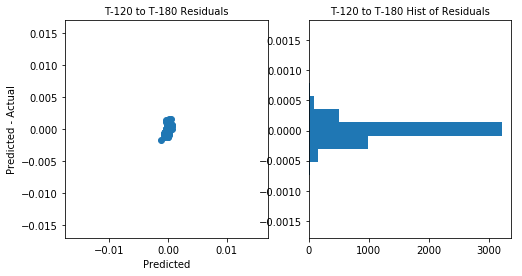

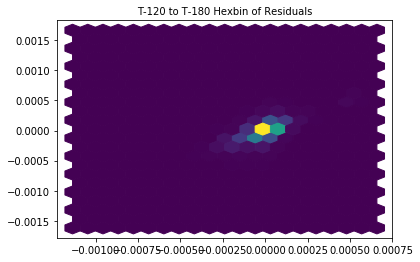

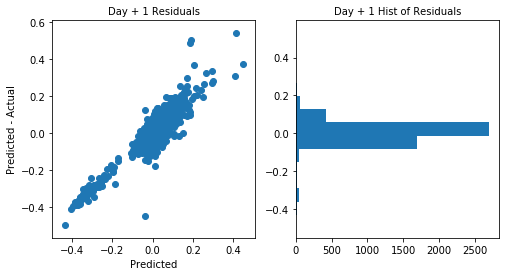

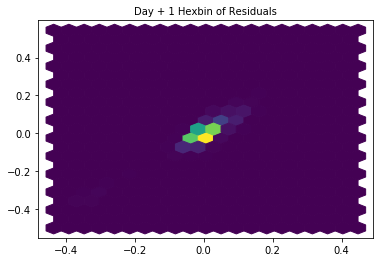

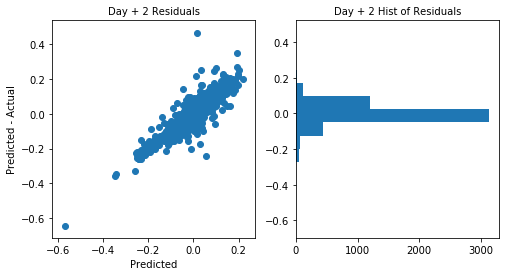

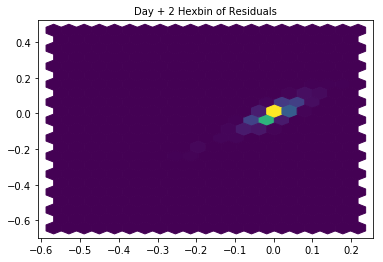

In [34]:
for col, title in enumerate(['T-120 to T-180', 'Day + 1', 'Day + 2']):
    resid_plot(y_pred[:, col], y_test.iloc[:, col], title)

# Model: KNN

From the previous residual plot there is still some variance left to be captured. I will use a KNN to hopefully capture this variance



In [43]:
from sklearn.neighbors import KNeighborsRegressor

In [44]:
model = Pipeline(steps = [
    ('minmax_scaler', MinMaxScaler()),
    ('RANSAC', KNeighborsRegressor(n_neighbors=5))])
x_train, x_test, y_train, y_test, w_train, w_test = \
    train_test_split(X_wfeatures,
                     Y_wfeatures,
                     w_wfeatures)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

WMAE(y_test.values, y_pred, weights=w_test.values)

23477.833659297

In [45]:
cross_validate(model, X_wfeatures.values, Y_wfeatures.values, w_wfeatures.values)

Cross Val Score: 62020.142204366915
 Cross Val Std: 5055.470687847354
 K: 3


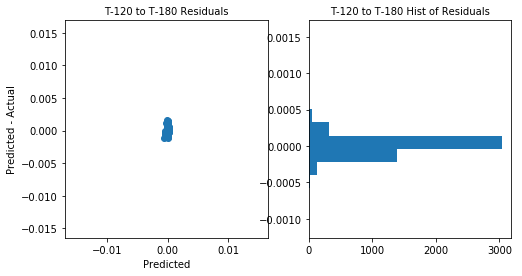

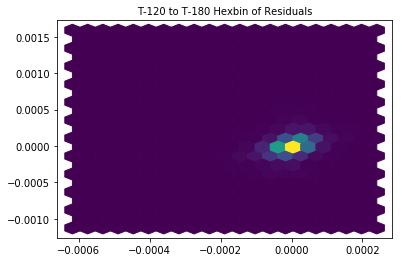

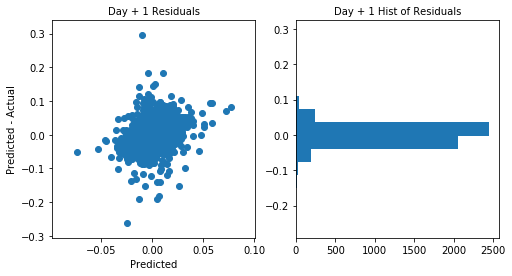

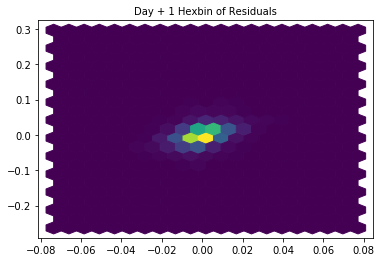

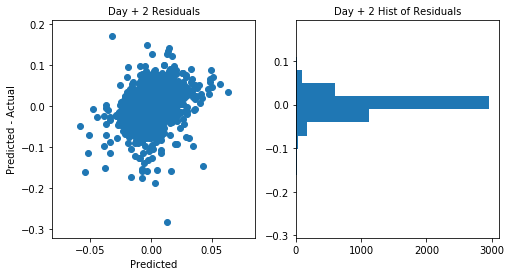

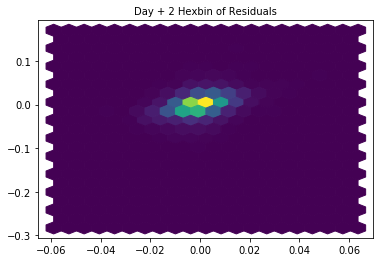

In [46]:
for col, title in enumerate(['T-120 to T-180', 'Day + 1', 'Day + 2']):
    resid_plot(y_pred[:, col], y_test.iloc[:, col], title)

# Feature Selection & Creation/Engineering

My feature selection strategy is non-existent. :-| (bad habits from playing with Neural Networks too much)

From the residual plots there isn't much variance left to capture. I need to add new features, and do some feature selection.

In [39]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression
# iris = load_iris()
# X, y = iris.data, iris.target
# X.shape

# X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
# X_new.shape

Since we have a lot of samples, I'm going to attempt to use mutual information to atleast retain the features that 

In [47]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor

X_eng_feat = X_wfeatures.copy()

X_eng_feat['Ret_Diff_D2_D1'] = X_wfeatures['Ret_MinusOne'] - X_wfeatures['Ret_MinusTwo']
X_eng_feat['Ret_Diff_D1_D0'] = X_wfeatures['intra_return_mean'] - X_wfeatures['Ret_MinusOne']
X_eng_feat['Ret_Diff_partial_D0_D2'] = X_wfeatures['intra_return_mean'] - X_wfeatures['Ret_MinusTwo']

Since we have a lot of samples, I'm going to attempt to use mutual information to atleast retain the features that contain a signal

In [64]:
model_1 = Pipeline(steps = [
    ('minmax_scaler', MinMaxScaler()),
    ('model1', Lasso())]) # Quickly select features with regularization.

model_2 = Pipeline(steps = [
    ('minmax_scaler', MinMaxScaler()),
    ('model2', Lasso())])

# cross_validate(model, X_eng_feat.values, Y_wfeatures.iloc[:, 0].values, w_wfeatures.iloc[:, 0]),\
cross_validate(model_1, X_eng_feat.values, Y_wfeatures.iloc[:, 1].values, w_wfeatures.iloc[:, 1]),\
cross_validate(model_2, X_eng_feat.values, Y_wfeatures.iloc[:, 2].values, w_wfeatures.iloc[:, 2]);

Cross Val Score: 47774.12645158001
 Cross Val Std: 984.70058106651
 K: 3
Cross Val Score: 45994.92222491507
 Cross Val Std: 5280.529732093032
 K: 3


In [ ]:
def resids(model, x, y):
    return None

In [ ]:
x_train, x_test, y_train, y_test, w_train, w_test = \
    train_test_split(X_wfeatures,
                     Y_wfeatures,
                     w_wfeatures)

model_1.fit(x_train, y_train.values[:, 1])
model_2.fit(x_train, y_train.values[:, 2])

y_pred_0 = np.zeros(x_test.shape)
y_pred_d1 = model_1.predict(x_test)
y_pred_d2 = model_2.predict(x_test)

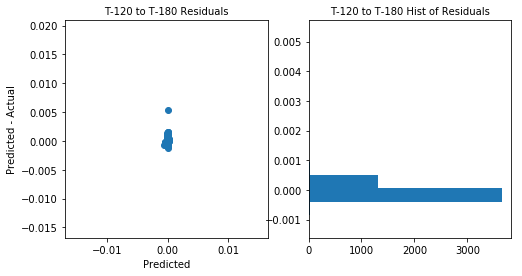

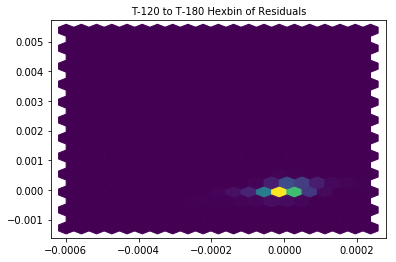

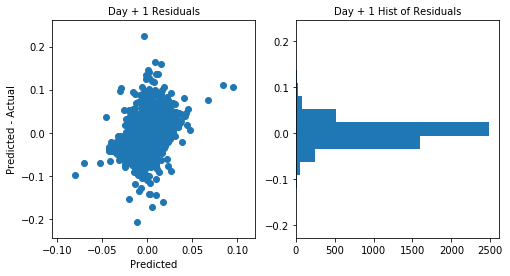

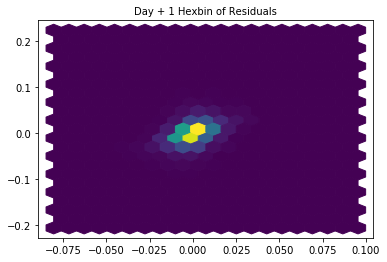

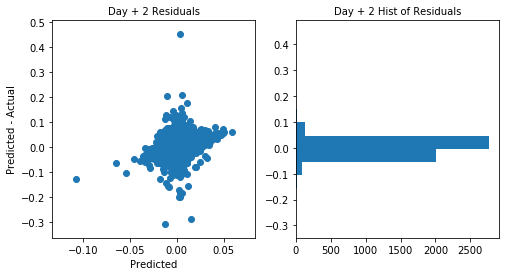

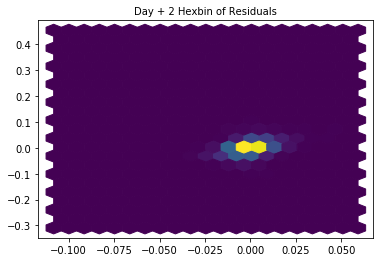

In [50]:
for col, title in enumerate(['T-120 to T-180', 'Day + 1', 'Day + 2']):
    resid_plot(y_pred[:, col], y_test.iloc[:, col], title)

### Stratified Cross validation sampling on Feature 7. (it's integered which means it might be some form of class, this kind of feels like somehting that wouldn't normally come up in non-hidden data but whatevs. 

### DTW (dynamic time warping) and Hierarchical clustering to turn the Ret_T features into perhaps useful feature.
inspiration from: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html


The thinking here is that I can use the 

### Sequence

Right now the ~2+ day window of exogenous variables predicting the next ~2+ days of returns has an underlying assumption that Times T121 - T180, D + 1, and D + 2 are all independent of one another. 

Being a time series problem. Let's look at modeling 

### Lomb Scargle? 